In [8]:
import torch
import math
import random
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import os
import glob
from PIL import Image
from torch import optim, nn
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [9]:
%%bash
rm -rf images

In [10]:
%%bash
mkdir images
wget -O images/Dataset.zip https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip 
mkdir images/original
unzip -d images/Dataset/ images/Dataset.zip
ls -v images/Dataset/Flicker8k_Dataset/ | cat -n | while read n f; do mv -n "images/Dataset/Flicker8k_Dataset/$f" "images/original/$n.jpg"; done
wget -O images/watermark.png https://drive.google.com/uc?id=19g2xehk2ygH4WWZu6G7ir883NNtVyjjo&export=download
mkdir images/watermarked
mkdir images/not_watermarked
mkdir images/watermark_locations/
rm -rf images/Dataset
rm -rf images/Dataset.zip

Output hidden; open in https://colab.research.google.com to view.

In [11]:
%%bash
ls -l images/original/ | grep -v ^d | wc -l

8092


In [12]:
def gen_watermark(og_img_path, watermark_img_path, output_path, not_marked_path, watermark_locations_path, w, h):
  # Read the original image + dimension
  og_img = glob.glob(og_img_path)

  print('Adding watermarks')
  samples = 0

  # Original image resizing dims
  resize_w = w
  resize_h = h

  total_means = [0, 0, 0]
  total_vars = [0, 0, 0]

  for i in og_img:
      img = Image.open(i)
      img = img.resize((resize_w, resize_h))
      img_w, img_h = img.size

      samples += 1

      filename = os.path.basename(i)
      number = int(filename.split('.')[0])
      # Save resized original image
      img.save(not_marked_path + filename)

      for colour in range(3):
        pixels = np.asarray(img.getdata(colour))
        pixels = pixels/255
        total_means[colour] += np.mean(pixels)
        total_vars[colour] += np.var(pixels)

      # Read the watermark image + dimension
      watermark = Image.open(watermark_img_path)

      WM_SIZE = random.choice([1.1, 1.2, 1.3])
      # Resize the watermark in proportion to original image
      basewidth = int(img_w // WM_SIZE)
      wpercent = (basewidth / float(watermark.size[0]))
      hsize = int((float(watermark.size[1]) * float(wpercent)))
      watermark = watermark.resize((basewidth, hsize), Image.ANTIALIAS)

      # If watermark image is not a PNG
      if watermark.mode!='RGBA':
          alpha = Image.new('L', watermark.size, 255)
          watermark.putalpha(alpha)

      watermark_w, watermark_h = watermark.size

      # Randomly assign watermark coordinates
      water_w, water_h = (random.randint(0, img_w - watermark_w), random.randint(0, img_h - watermark_h))

      coords = torch.ones(resize_h, resize_w)
      coords[water_h:water_h+watermark_h, water_w:water_w + watermark_w] = 0
      torch.save(coords, open(watermark_locations_path + filename, 'wb'))
                
      # Randomly select transparency
      TRANSPARENCY = random.randint(40, 100)
      paste_mask = watermark.split()[3].point(lambda i: i * TRANSPARENCY / 100.)
      img.paste(watermark, (water_w, water_h), mask=paste_mask)
      
      filename = os.path.basename(i)
      # Save watermarked image
      img.save(output_path + filename)

  print('Watermark added to {} images'.format(samples))
  for colour in range(3):
    total_means[colour] = total_means[colour]/samples
    total_vars[colour] = math.sqrt(total_vars[colour]/samples)
  print('Pixel mean (RGB):', total_means)
  print('Pixel standard deviation (RGB):', total_vars)
  return samples, tuple(total_means), tuple(total_vars)

In [16]:
width=128#400
height=128#400
colors=3
og_img_path = 'images/original/*.*'
watermark_img_path = 'images/watermark.png'
output_path = 'images/watermarked/'
not_marked_path = 'images/not_watermarked/'
watermark_location_path='images/watermark_locations/'
samples, pixel_mean, pixel_standard_deviation = gen_watermark(og_img_path, watermark_img_path, output_path, not_marked_path, watermark_location_path, width, height)

Adding watermarks
Watermark added to 8091 images
Pixel mean (RGB): [0.4580307640238337, 0.446099217206731, 0.4039171211065012]
Pixel standard deviation (RGB): [0.23636878228574512, 0.2272482844976788, 0.2332075436563507]


In [17]:
class watermarkDataset:
  def __init__(self, original_path, watermarked_path, len, watermark_location_path, transform=None, output_transform=None):
        self.original_path = original_path
        self.watermarked_path = watermarked_path
        self.length = len
        self.transform = transform
        self.output_transform = output_transform
        self.watermark_location_path = watermark_location_path

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    # print(idx)
    if torch.is_tensor(idx):
        idx = idx.tolist()
    idx +=1
    original_img_name = os.path.join(self.original_path,
                            str(idx) + '.jpg')
    watermarked_img_name = os.path.join(self.watermarked_path,
                            str(idx) + '.jpg')
    watermark_location_name = os.path.join(self.watermark_location_path,
                            str(idx) + '.jpg')

    original_image = Image.open(original_img_name)
    watermarked_image = Image.open(watermarked_img_name)
    watermark_location = torch.load(open(watermark_location_name, 'rb'))
    if original_image is None or watermarked_image is None:
      print(original_img_name)
      print(watermarked_img_name)

    if self.transform:
      original_image = self.transform(original_image)
    if self.output_transform:
      watermarked_image = self.output_transform(watermarked_image)

    return original_image, watermarked_image, watermark_location

In [18]:
tform = transforms.Compose([transforms.ToTensor() ,transforms.Normalize(pixel_mean, pixel_standard_deviation)])

data = watermarkDataset('images/not_watermarked/',
                        'images/watermarked/',
                        len=samples,
                        watermark_location_path=watermark_location_path,
                        transform=tform,
                        output_transform=tform)

In [19]:
def get_data_loader(data, batch_size):
  train_data, validation_data = torch.utils.data.random_split(data, [samples - 1000, 1000])
  loader_kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True,
    'drop_last': True,
  }
  train_loader = DataLoader(train_data, **loader_kwargs)
  val_loader = DataLoader(validation_data, **loader_kwargs)
  return train_loader, val_loader

In [20]:
class our_loss():
  def __init__(self, watermark_weight):
    self.watermark_weight = watermark_weight

  def evaluate(self, source, target, locations):
    locations[locations==0] = self.watermark_weight
    locations = torch.unsqueeze(locations, 1)
    loss = source-target
    loss = loss * locations
    loss = torch.square(loss)
    loss = loss.sum()
    return loss

In [21]:
class unnormalize_data():
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def denorm(self, data):
    for colour in range(3):
      data[:, colour, :, :] = data[:, colour, :, :] * self.std[colour] + self.mean[colour]
    return data

In [22]:
class myCNN(nn.Module):

  def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
      super(myCNN, self).__init__()
      kernel_size = 3
      padding = 1
      layers = []
      layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
      layers.append(nn.ReLU(inplace=True))
      for _ in range(depth-2):
          layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
          layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum=0.95))
          layers.append(nn.ReLU(inplace=True))
      layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
      self.dncnn = nn.Sequential(*layers)
      self._initialize_weights()

  def forward(self, x):
      watermarked = x
      watermark = self.dncnn(x)
      return watermarked-watermark

  def _initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.orthogonal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

In [23]:
def eval_acc(model, data_loader, unnorm, loss_func, num_samples=5):
  count = 0
  val_acc = 0
  with torch.no_grad():
    model.eval()
    for batch, data in enumerate(data_loader):
      data = [d.cuda() for d in data]
      original, watermarked, locations = data
      pred = model(watermarked)

      original = unnorm.denorm(original)
      watermarked = unnorm.denorm(watermarked)
      pred = unnorm.denorm(pred)
      val_acc += loss_func.evaluate(original, pred, locations)
      count +=1
      if batch < num_samples:
        print(f'=== Sample {batch + 1} ===')
        print('input:')
        pil_image = transforms.ToPILImage()(watermarked[0])
        display(pil_image)
        print('target:')
        pil_image = transforms.ToPILImage()(original[0])
        display(pil_image)
        print('pred:')
        pil_image = transforms.ToPILImage()(pred[0])
        display(pil_image)
  return val_acc/count

In [24]:
def train(model, train_loader, val_loader, unnorm, num_epochs, lr, loss_func):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  
  loss_history = []
  for epoch in range(num_epochs):
    current_loss = 0.0
    val_acc = eval_acc(model, val_loader, unnorm, loss_func, num_samples=0)
    for batch, data in enumerate(train_loader):
      data = [d.cuda() for d in data]
      original, watermarked, locations = data
      optimizer.zero_grad()
      pred = model(watermarked)
      loss = loss_func.evaluate(original, pred, locations)
      loss.backward()
      optimizer.step()
      current_loss += loss.item()
      loss_history.append(loss.item())
      with torch.no_grad():
        loss_history.append(loss.item())
        if batch == 0:
          print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
            epoch, loss.item(), val_acc))
  
  return model, loss_history

In [25]:
torch.manual_seed(0)
torch.cuda.empty_cache()

batch_size = 50
num_epochs = 100
learning_rate = 0.0001

set_unnorm =  unnormalize_data(pixel_mean, pixel_standard_deviation)
my_loss = our_loss(watermark_weight=2)

train_loader, val_loader = get_data_loader(data, batch_size)
model = myCNN(image_channels = 3)
model = model.cuda()

model, loss_history = train(model, train_loader, val_loader, set_unnorm, num_epochs, learning_rate, my_loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch:   0 	 Loss: 752508.812500 	 Val Acc: 34104.750000
Train Epoch:   1 	 Loss: 267577.437500 	 Val Acc: 15011.151367
Train Epoch:   2 	 Loss: 171899.500000 	 Val Acc: 9576.445312
Train Epoch:   3 	 Loss: 145174.828125 	 Val Acc: 6993.829590
Train Epoch:   4 	 Loss: 120918.125000 	 Val Acc: 6182.055176
Train Epoch:   5 	 Loss: 92902.351562 	 Val Acc: 5541.811035
Train Epoch:   6 	 Loss: 105900.531250 	 Val Acc: 5420.734863
Train Epoch:   7 	 Loss: 89036.335938 	 Val Acc: 4825.465820
Train Epoch:   8 	 Loss: 94831.382812 	 Val Acc: 4677.442871
Train Epoch:   9 	 Loss: 83525.015625 	 Val Acc: 4354.497070
Train Epoch:  10 	 Loss: 65555.093750 	 Val Acc: 4335.293945
Train Epoch:  11 	 Loss: 64119.917969 	 Val Acc: 4134.632324
Train Epoch:  12 	 Loss: 85430.343750 	 Val Acc: 4556.981934
Train Epoch:  13 	 Loss: 67738.640625 	 Val Acc: 4016.271240
Train Epoch:  14 	 Loss: 72774.234375 	 Val Acc: 4126.870605
Train Epoch:  15 	 Loss: 72962.554688 	 Val Acc: 3780.107910
Train Epoch:  16

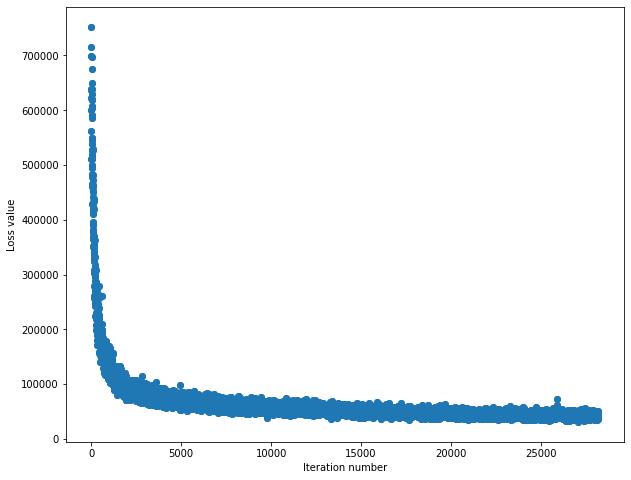

In [26]:
plt.plot(loss_history, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [27]:
train_acc = eval_acc(model, train_loader, set_unnorm, my_loss, num_samples=49)
print('Training Accuracy:', train_acc)

Output hidden; open in https://colab.research.google.com to view.